In [1]:
%who

Interactive namespace is empty.


In [2]:
import xarray as xr
import numpy as np
import pandas as pd
import sys
new_path = '/home/566/ad9701/drought_probability/final_code_AU/'
if new_path not in sys.path:
    sys.path.append(new_path)
import validation_functions as myfunc
import matplotlib.pyplot as plt

SMALL_SIZE = 12
MEDIUM_SIZE = 14
BIGGER_SIZE = 14

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

out_dir ='figures/drought_2017to2020/droughtBreak_prob/'

### Times that were in drought most of the time

In [3]:
! ls /g/data/w97/ad9701/drought_2017to2020/drought_breakProb/awra/sm_droughts/

events_1911-01_1911-12.nc  sm_deficits_1911-01_1911-12.nc
events_1912-01_1912-12.nc  sm_deficits_1912-01_1912-12.nc
events_1913-01_1913-12.nc  sm_deficits_1913-01_1913-12.nc
events_1914-01_1914-12.nc  sm_deficits_1914-01_1914-12.nc
events_1915-01_1915-12.nc  sm_deficits_1915-01_1915-12.nc
events_1916-01_1916-12.nc  sm_deficits_1916-01_1916-12.nc
events_1917-01_1917-12.nc  sm_deficits_1917-01_1917-12.nc
events_1918-01_1918-12.nc  sm_deficits_1918-01_1918-12.nc
events_1919-01_1919-12.nc  sm_deficits_1919-01_1919-12.nc
events_1920-01_1920-12.nc  sm_deficits_1920-01_1920-12.nc
events_1921-01_1921-12.nc  sm_deficits_1921-01_1921-12.nc
events_1922-01_1922-12.nc  sm_deficits_1922-01_1922-12.nc
events_1923-01_1923-12.nc  sm_deficits_1923-01_1923-12.nc
events_1924-01_1924-12.nc  sm_deficits_1924-01_1924-12.nc
events_1925-01_1925-12.nc  sm_deficits_1925-01_1925-12.nc
events_1926-01_1926-12.nc  sm_deficits_1926-01_1926-12.nc
events_1927-01_1927-12.nc  sm_deficits_1927-01_1927-12.nc
events_1928-01

In [5]:
data_dir = '/g/data/w97/ad9701/drought_2017to2020/drought_breakProb/awra/sm_droughts/'
time_slice = slice('2016-01-01', '2020-12-31')
lon_slice = slice(135, 154)
lat_slice = slice(-20, -44)

ds_area = xr.open_dataset('/g/data/w97/ad9701/p_prob_analysis/temp_files/awra_gridarea_cdo.nc')
da_area = ds_area['cell_area'].rename({'latitude':'lat', 'longitude':'lon'}).sel(lat = lat_slice, lon = lon_slice)

mask_file = '/g/data/w97/ad9701/drought_2017to2020/AWRA_mask_drought_focusArea.nc'
ds_mask = xr.open_dataset(mask_file)
da_mask = ds_mask['mask'].sel(lat = lat_slice, lon = lon_slice)

total_area = (da_mask*da_area).sum(['lat', 'lon']).values  #in sq.m
    
ds_events = xr.open_mfdataset(data_dir + 'events_20[1-2]*.nc')
da_events = ds_events['sm_drought'].sel(time = time_slice)

# theres some mismatch between lat-lons
da_events = da_events.assign_coords({'lat':da_mask.lat.values, 'lon':da_mask.lon.values})

# Fraction of the region in drought
da_areaFrac_drought = ((da_events*da_area*da_mask).sum(['lat', 'lon'])/total_area)

In [41]:
import matplotlib.pyplot as plt

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 18

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

Text(0, 0.5, 'fraction')

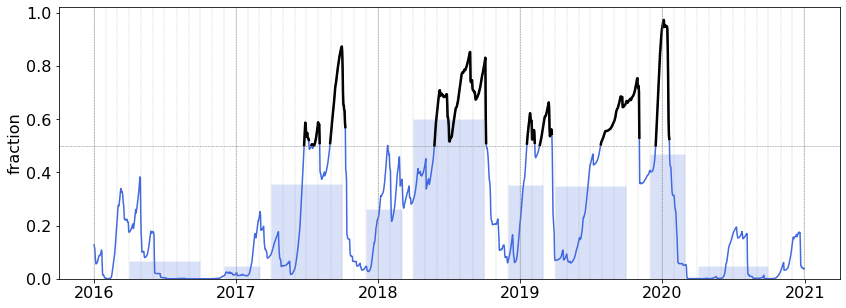

In [6]:
import pandas as pd
out_dir = 'figures/drought_2017to2020/droughtBreak_prob/'

#da_lwe_monAnom_regAvg_wNan.plot.line(color="royalblue", marker="o", linewidth=1, size=5, aspect=3)
fig, ax = plt.subplots(nrows=1,ncols=1,
                       figsize=(14,5)) #width, height

seas_breaks = pd.date_range('2015-12-31', freq='M', periods=12*5+1).to_numpy()#.astype(float)
year_breaks = pd.date_range('2015-12-31', freq='Y', periods=6).to_numpy()

# cool season
amjjas_ind = np.isin(da_areaFrac_drought['time.month'], [4, 5, 6, 7, 8, 9])
da_coolseas_mean = da_areaFrac_drought.isel(time = amjjas_ind).groupby('time.year').mean()

# the three DJFs in between
da_DJF_mean = da_areaFrac_drought.resample(time="QS-DEC").mean().sel(time = ['2016-12-01', '2017-12-01', '2018-12-01', '2019-12-01'])

# .resample(time="QS-DEC").mean().time.values + 
# np.timedelta64(45, 'D')
# time array for time point in the middle of AMJJAS
array_time_coolseas = [x.astype('datetime64[D]') for x in np.array(pd.date_range('2016-06-01', freq='Y', periods=5) - np.timedelta64(6, 'M'))]
array_time_DJF = [x.astype('datetime64[D]') for x in da_DJF_mean.time.values + np.timedelta64(45, 'D')]

plt.bar(array_time_coolseas, da_coolseas_mean.values, width=91*2, edgecolor='white', color='royalblue', alpha=0.2)
plt.bar(array_time_DJF, da_DJF_mean.values, width=91, edgecolor='white', color='royalblue', alpha=0.2)
plt.plot(da_areaFrac_drought.time.values, da_areaFrac_drought.values, color="royalblue", marker="o", linewidth=1.5, markersize=0)
plt.plot(da_areaFrac_drought.time.values, da_areaFrac_drought.where(da_areaFrac_drought>0.5).values, color="black", marker="o", linewidth=2.5, markersize=0)

for xline in seas_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.2)
for xline in year_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.5)
for yline in [0.5]:
    plt.axhline(yline, color = 'grey', linestyle = '--', linewidth = 0.5)
plt.axhline(0, color = 'black', linestyle = 'solid', linewidth = 0.5)
plt.xlabel('')
plt.ylabel('fraction')
#fig.savefig(out_dir + 'proportion_of_region_inDrought_600dpi.png', bbox_inches='tight', dpi=600)

### GLM Results

In [22]:
! ls /g/data/w97/ad9701/drought_2017to2020/drought_breakProb/awra/

GLM_results  GLM_results_fullRec  sm_1980to2016_perc  sm_droughts


In [23]:
import glob

input_dir = '/g/data/w97/ad9701/drought_2017to2020/drought_breakProb/awra/GLM_results_fullRec/sm_week8/concat_time_lon/'
start_lat = np.linspace(-21.025, -37.025, 9)
end_lat = start_lat - 2
fname_prefix = 'GLM_results_'
fname_suffix = '_*'
#da = myfunc.concatLat_results(start_lat, end_lat, input_dir, fname_prefix, fname_suffix)

file_names = []
for i in range(len(start_lat)):
    file_names.extend(glob.glob(input_dir + fname_prefix + 'lat' + str(start_lat[i]) + '_' + str(end_lat[i]) + fname_suffix + '.nc'))

ds = xr.open_mfdataset(file_names)

fname_prefix = 'probability_contributions/GLM_base_probability_'
contrib_results_files = []
for i in range(len(start_lat)):
    file_names.extend(glob.glob(input_dir + fname_prefix + 'lat' + str(start_lat[i]) + '_' + str(end_lat[i]) + fname_suffix + '*.nc'))

ds_contrib = xr.open_mfdataset(file_names)

### Evolution of probability through time

In [24]:
# Average probabilitiy over the drought region

da_mask_temp = da_mask.sel(lat = slice(-21.025, -39.025), lon = slice(137.025, 155.025))
da_mask_temp = da_mask_temp.assign_coords({'lat':ds.lat.values, 'lon':ds.lon.values})
# (ds['glm_probability']*da_mask_temp).mean(['lat', 'lon']).plot()
da_avgProb = (ds['glm_probability']*da_mask_temp).mean(['lat', 'lon'])

da_base_prob = ds_contrib['GLM_base_prob']
da_soi_contrib_avg = ((ds_contrib['GLM_base_prob_wsoi']-ds_contrib['GLM_base_prob'])*da_mask_temp).mean(['lat', 'lon'])
da_dmi_contrib_avg = ((ds_contrib['GLM_base_prob_wdmi']-ds_contrib['GLM_base_prob'])*da_mask_temp).mean(['lat', 'lon'])

In [25]:
da_base_prob_avg = (ds_contrib['GLM_base_prob']*da_mask_temp).mean(['lat', 'lon'])

### Evolution of probabilities & contributions. Supplementary Figure

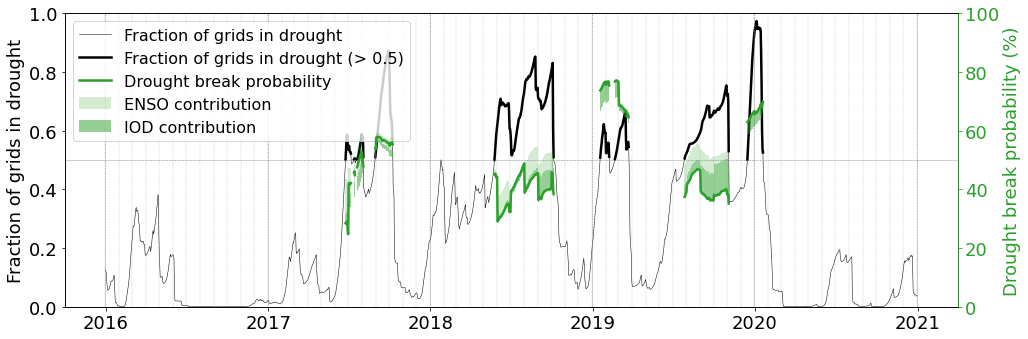

In [42]:
import pandas as pd
from matplotlib.patches import Patch
import seaborn as sns

out_dir = 'figures/drought_2017to2020/droughtBreak_prob/'
width_sel = 0.9999
align_sel = 'center'
             
col_sel = sns.color_palette()[2]
    
fig, ax = plt.subplots(nrows=1,ncols=1,
                       figsize=(16,6*0.9)) #width, height

seas_breaks = pd.date_range('2015-12-31', freq='M', periods=12*5+1).to_numpy()#.astype(float)
year_breaks = pd.date_range('2015-12-31', freq='Y', periods=6).to_numpy()

list_legend = []

list_legend.append(plt.plot(da_areaFrac_drought.time.values, da_areaFrac_drought.values, color="black", marker="o", linewidth=0.5, markersize=0, label = 'Fraction of grids in drought')[0])
list_legend.append(plt.plot(da_areaFrac_drought.time.values, da_areaFrac_drought.where(da_areaFrac_drought>0.5).values, color="black", marker="o", linewidth=2.5, markersize=0, label = 'Fraction of grids in drought (> 0.5)')[0])

ax_twin = ax.twinx()

ax_twin.spines['right'].set_color(col_sel)
ax_twin.xaxis.label.set_color(col_sel)
ax_twin.tick_params(axis='y', colors=col_sel)

# ax.spines['right'].set_color('black')

# list_legend.append(axs0_twin.plot(da_def_sel.time.values, da_def_sel.values, color=def_col, linewidth=0.75, label='soil mois. deficit')[0])
# axs0_twin.set_ylabel('Deficit (mm)')
# list_legend.append(axs[iAx].plot(da_prob.time.values, da_prob.values, color=col_sel, linewidth=1.5, markersize=10, label='prob. at ' + str(ts_sel) + '-weeks')[0])

#list_legend.append(ax_twin.plot(da_base_prob_avg.time.values, da_base_prob_avg.where(da_areaFrac_drought>0.5).values*100, color=col_sel, marker="o", linewidth=0.3, markersize=0, label = 'Probability')[0])

list_legend.append(ax_twin.plot(da_avgProb.time.values, da_avgProb.where(da_areaFrac_drought>0.5).values*100, color=col_sel, marker="o", linewidth=2.5, markersize=0, label = 'Drought break probability')[0])

y_offset = da_base_prob_avg.values
ax_twin.bar(da_soi_contrib_avg.time.values, da_soi_contrib_avg.where(da_areaFrac_drought>0.5).values*100, color=col_sel, linewidth=1.5, 
         label='ENSO contribution', alpha=0.2, bottom = y_offset*100, width=width_sel, align=align_sel)

list_legend.append(Patch(facecolor=col_sel, alpha=0.2, label='ENSO contribution'))

oppContrib = (da_dmi_contrib_avg.values*da_soi_contrib_avg.values)<0  # days where the contributions are opposite in sign - need to set the bottom of the dmi bar to zero on these days
y_offset = da_soi_contrib_avg.values
y_offset = np.where(~np.isnan(y_offset), y_offset, 0)
y_offset = y_offset + da_base_prob_avg.values
y_offset[oppContrib]= da_base_prob_avg.values[oppContrib]
ax_twin.bar(da_dmi_contrib_avg.time.values, da_dmi_contrib_avg.where(da_areaFrac_drought>0.5).values*100, color=col_sel, linewidth=2, 
         label='IOD contribution ', alpha=0.5, bottom = y_offset*100, width=width_sel, align=align_sel)
list_legend.append(Patch(facecolor=col_sel, alpha=0.5, label='IOD contribution'))

for xline in seas_breaks:
    ax.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.2)
for xline in year_breaks:
    ax.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.5)
for yline in [50]:
    ax_twin.axhline(yline, color = 'grey', linestyle = '--', linewidth = 0.5)
ax.axhline(0, color = 'black', linestyle = 'solid', linewidth = 0.5)
plt.xlabel('')
plt.ylabel('') #'Fraction of grids in drought, \n or Probability')

#ax2 = ax.twinx()
#plt.plot(da_avgProb.time.values, da_avgProb.values, color="red", marker="o", linewidth=0.5, markersize=0)
ax_twin.set_ylabel('Drought break probability (%)', color=col_sel)
ax.set_ylabel('Fraction of grids in drought')
# plt.ylim([0, 1])
# ax2.set_yticklabels(color='red')
#plt.legend(loc=0)

ax.set_ylim([0, 1])
ax_twin.set_ylim([0, 100])

lns = list_legend
labs = [l.get_label() for l in lns]
# if iDr == 0:
ax.legend(lns, labs, loc=2)

fig.savefig(out_dir + 'droughtBreak_prob_n_proportion_of_region_inDrought_600dpi_withContrib_May2023_update.png', bbox_inches='tight', dpi=600)
fig.savefig(out_dir + 'droughtBreak_prob_n_proportion_of_region_inDrought_600dpi_withContrib_May2023_update.pdf', bbox_inches='tight', format='pdf')

### Evolution of large scale climate drivers

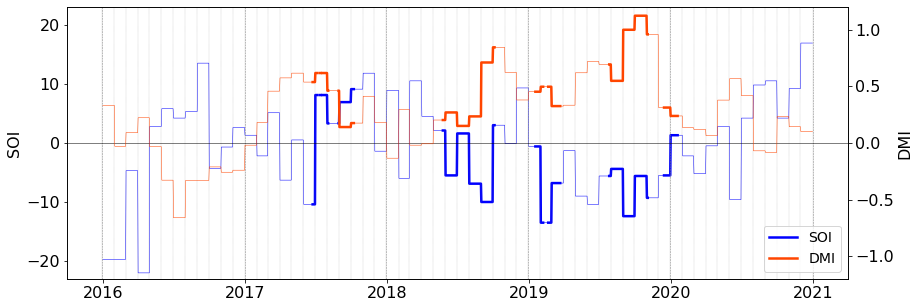

In [122]:
out_dir = 'figures/drought_2017to2020/droughtBreak_prob/'

#da_lwe_monAnom_regAvg_wNan.plot.line(color="royalblue", marker="o", linewidth=1, size=5, aspect=3)
fig, ax = plt.subplots(nrows=1,ncols=1,
                       figsize=(14,5)) #width, height

seas_breaks = pd.date_range('2015-12-31', freq='M', periods=12*5+1).to_numpy()#.astype(float)
year_breaks = pd.date_range('2015-12-31', freq='Y', periods=6).to_numpy()

plt.plot(ds.time.values, ds['soi'][0,0,:].values, color="blue", marker="o", linewidth=0.5, markersize=0)
plt.plot(ds.time.values, ds['soi'][0,0,:].where(da_areaFrac_drought>0.5).values, color="blue", marker="o", linewidth=2.5, markersize=0, label='SOI')
# plt.plot(da_areaFrac_drought.time.values, da_areaFrac_drought.where(da_areaFrac_drought>0.5).values, color="black", marker="o", linewidth=2.5, markersize=0, label = 'Drought Area Fraction')

for xline in seas_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.2)
for xline in year_breaks:
    plt.axvline(xline, color = 'grey', linestyle = '--', linewidth = 0.5)
# for yline in [0.5]:
#     plt.axhline(yline, color = 'grey', linestyle = '--', linewidth = 0.5)
plt.axhline(0, color = 'black', linestyle = 'solid', linewidth = 0.5)
plt.xlabel('')
plt.ylabel('SOI') #, color='blue')
#plt.legend(loc=4)
plt.ylim((-23, 23))

ax2 = ax.twinx()
ax2.plot(ds.time.values, ds['dmi'][0,0,:].values, color="orangered", marker="o", linewidth=0.5, markersize=0)
plt.plot(ds.time.values, ds['dmi'][0,0,:].where(da_areaFrac_drought>0.5).values, color="orangered", marker="o", linewidth=2.5, markersize=0, label='DMI')
plt.ylabel('DMI') #, color='orangered')
#plt.legend(loc=0)
plt.ylim((-1.2, 1.2))

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='blue', lw=2.5),
                Line2D([0], [0], color='orangered', lw=2.5)]
ax.legend(custom_lines, ['SOI', 'DMI'], loc=4)

fig.savefig(out_dir + 'climate_drivers_600dpi.png', bbox_inches='tight', dpi=600)

### Spatial patterns

In [68]:
ds = ds.assign_coords({'lon':np.round(ds.lon.values.astype('float64'), 2), 'lat':np.round(ds.lat.values.astype('float64'), 2)})

In [82]:
plot_list = []

for year in range(2016, 2021):
    # the mean probability during the month
    da_prob_mean = ds['glm_probability'].sel(time = str(year)).groupby('time.month').mean('time')
    
    # the proportion of the month that was in drought
    da_mon_prop = (da_events.sel(time = str(year)).groupby('time.month').sum('time'))/(da_events.sel(time = str(year)).groupby('time.month').count('time'))
    da_mon_prop = xr.where(da_mon_prop > 0.5, 1, np.nan)  # more than have the days in a month is in drought
    
    # keep only the estimates where atleast half the month is in drought
    da_plot_temp = (da_prob_mean*da_mon_prop).rename({'month':'time'}).assign_coords({'time':pd.date_range(str(year)+'-01', periods=12, freq='M')})
    plot_list.extend([da_plot_temp.isel(time = i) for i in range(12)])

#da_temp.plot(col = 'month', col_wrap = 6)

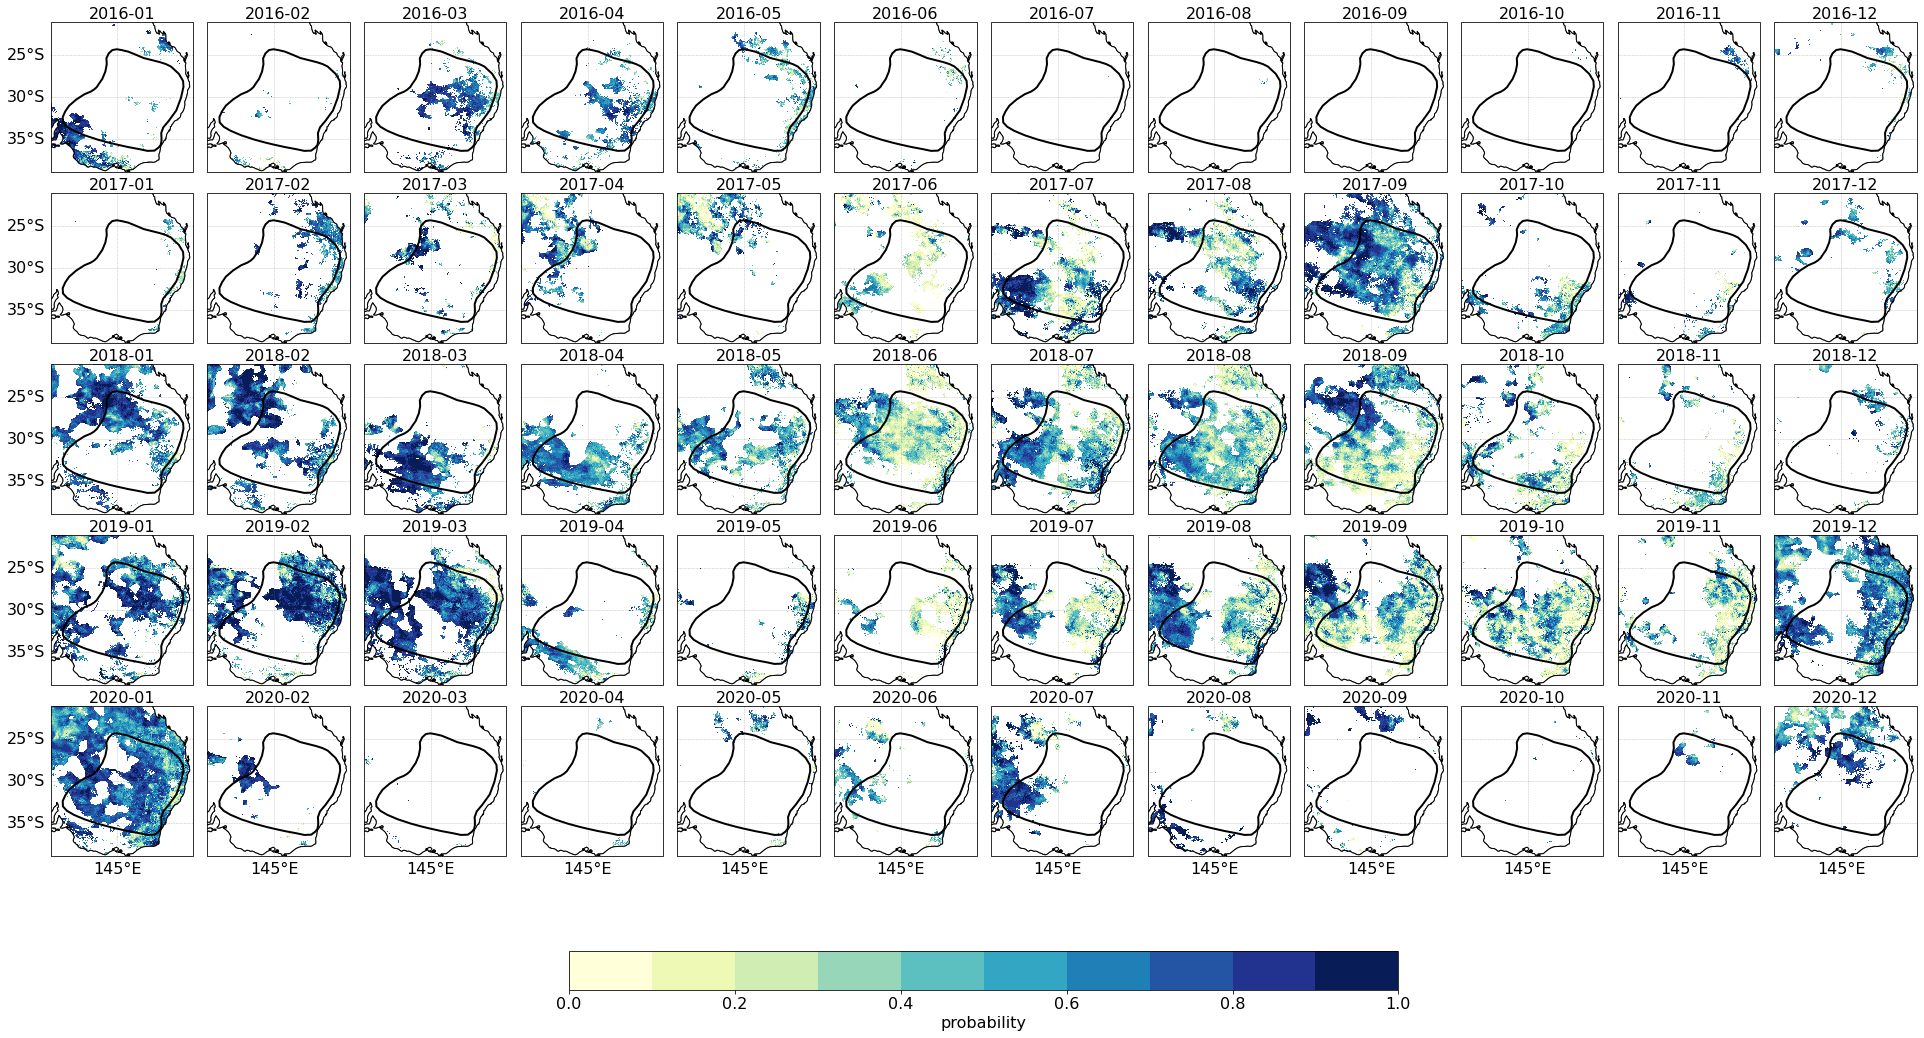

In [85]:
# lat_sel = slice(-22, -39)
# plot_list = [da_seas.sel(season = seas, quantile = q, lat = lat_sel) for q in qSel for seas in seasName] #(seas, q) in zip(seasName, qSel)]
# subtitle_list = [seas + ', quantile = ' + str(q) for q in qSel for seas in seasName]

subtitle_list = [x.astype('datetime64[M]') for x in np.array(pd.date_range('2016-01', periods=12*5, freq='M'))]

out_dir ='figures/drought_2017to2020/droughtBreak_prob/'
out_figname = 'spatial_patterns_bymon_probabilities'

cmap = 'YlGnBu'
levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]
shCol = 'black'
sh_file = '/g/data/w97/ad9701/drought_2017to2020/drought_focusArea/smooth_polygon_drought_focusArea.shp'
plot_obj = myfunc.draw_pcolormesh_Npanels(plot_list, cmap = cmap, ncols = 12, nrows = 5, panel_width=2.4, panel_height=3.6, levels=levels, 
                                shapefile = sh_file, shapefile_color = shCol,subplot_title=subtitle_list,
                                cbar_label='probability', longer_cbar = False, cbar_extend='neither', out_dir = out_dir, out_figname = out_figname, fig_dpi = 600)